# Кластеризация k-means

Данные столбцов:

- culmen_length_mm: длина верхнего края клюва пингвина (миллиметр)

- culmen_depth_mm: глубина верхнего края клюва пингвина (миллиметр)

- flipper_length_mm: длина ласт (миллиметр)

- body_mass_g: масса тела (грамм)

- sex: пол пингвина 

## Импортируем данные

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples, make_scorer
from sklearn.model_selection import GridSearchCV
import joblib

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('penguins.csv')
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


## Проведем EDA (Exploratory Data Analysis) - первичный анализ данных

In [4]:
# Функция для числовых столбцов
def eda_num_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Минимальное значение": df.min(),
            "Максимальное значение": df.max(),
            "Среднее значение": df.mean(),
            "Медиана": df.median(),
            "Дисперсия": df.var(),
            "Квантиль 0.1": df.quantile(0.1),
            "Квантиль 0.9": df.quantile(0.9),
            "Квартиль 1": df.quantile(0.25),
            "Квартиль 3": df.quantile(0.75)
        }
    )

    return x

In [5]:
# Функция для категориальных столбцов
def eda_cat_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Количество уникальных значений": df.nunique(),
            "Мода": df.mode().iloc[0]
        }
    )
    
    return x

In [6]:
col_num = df.select_dtypes(include=["number"]).columns
eda_num_info(df[col_num])

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
culmen_length_mm,0.005814,32.1,59.6,43.921930,44.45,29.807054,36.6,50.8,39.225,48.50
culmen_depth_mm,0.005814,13.1,21.5,17.151170,17.30,3.899808,14.3,19.5,15.600,18.70
flipper_length_mm,0.005814,-132.0,5000.0,214.014620,197.00,67890.501252,185.0,221.0,190.000,213.75
body_mass_g,0.005814,2700.0,6300.0,4201.754386,4050.00,643131.077327,3300.0,5400.0,3550.000,4750.00


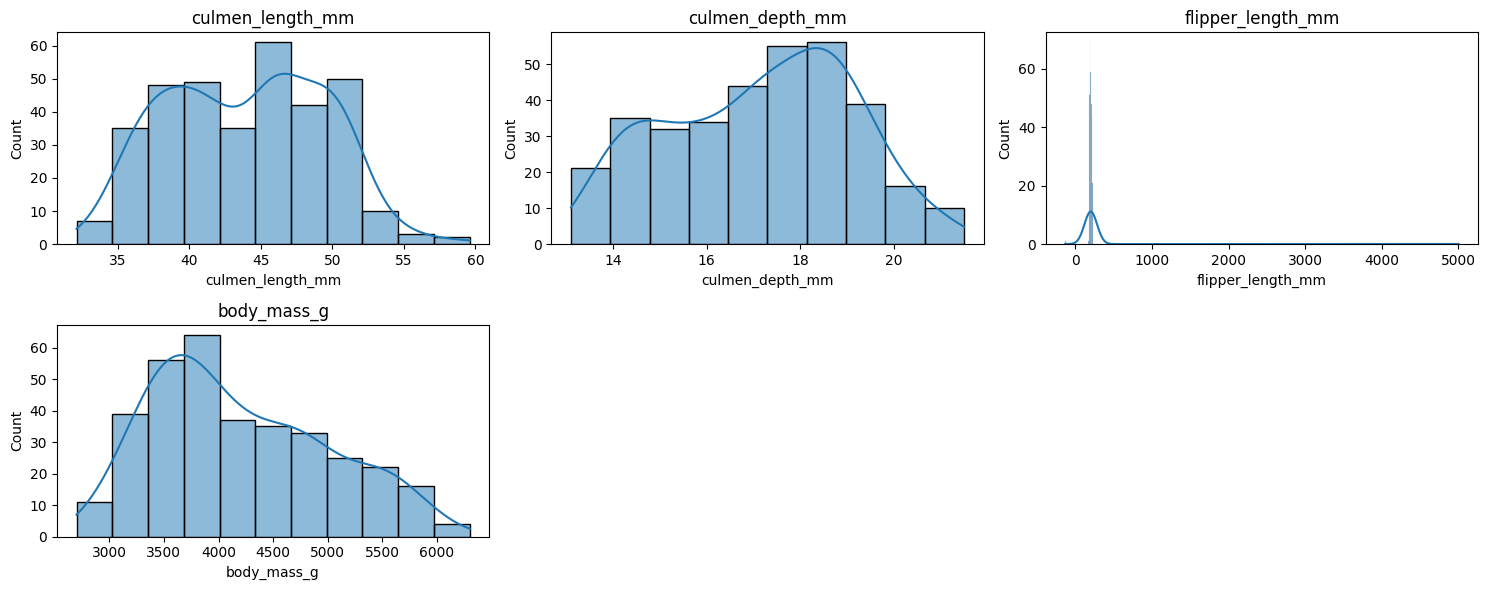

In [7]:
# Визуализация гистограмм
def plot_histograms(df):
    # Определить количество строк и столбцов для подграфиков
    n_cols = 3
    n_rows = (len(df.columns) + n_cols - 1) // n_cols
    
    # Создать фигуру с нужным размером
    plt.figure(figsize=(n_cols * 5, n_rows * 3))
    
    for i, column in enumerate(df.columns, start=1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[column], kde=True)
        
        # Добавить название столбца как заголовок графика
        plt.title(column)
        
    plt.tight_layout()
    plt.show()

# Применение функции к DataFrame df
plot_histograms(df[col_num])

Видим, что гистограмма длины ласт (*flipper_lenght_mm*) пингвинов имеет выбросы и отрицательные значения. Остальные данные в порядке.

In [8]:
col_cat = df.select_dtypes(include=["object"]).columns
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
sex,0.026163,3,MALE


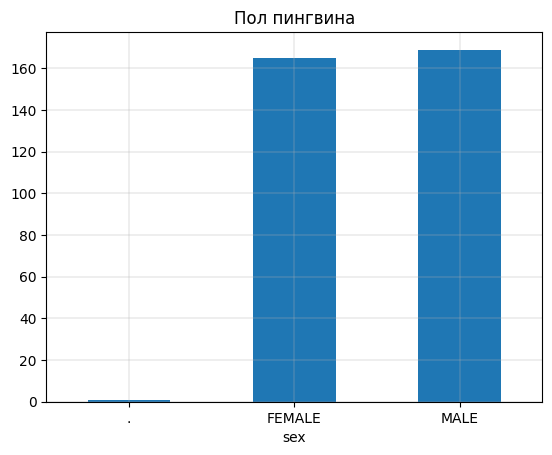

In [9]:
df['sex'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=0)
plt.grid(linewidth=0.3)
plt.title('Пол пингвина')
plt.show()

In [10]:
df['sex'].unique()

array(['MALE', 'FEMALE', nan, '.'], dtype=object)

In [11]:
df['sex'].value_counts()

sex
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

Видим, что помимо пропусков данных в столбце пола имеется аномалия - третье значение, обозначенное `.`. Заменим эту аномалию модой.

In [12]:
df['sex'].replace('.', df['sex'].mode()[0], inplace=True)

In [13]:
df['sex'].unique()

array(['MALE', 'FEMALE', nan], dtype=object)

In [14]:
df['sex'].value_counts()

sex
MALE      170
FEMALE    165
Name: count, dtype: int64

## Обработка пропусков

In [15]:
print("Количество пропусков в числовых столбцах:")
print(df[col_num].isnull().sum())
print("\nКоличество пропусков в категориальных столбцах:")
print(df[col_cat].isnull().sum())

Количество пропусков в числовых столбцах:
culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
dtype: int64

Количество пропусков в категориальных столбцах:
sex    9
dtype: int64


In [16]:
# Заполняем пропуски числовых переменных медианой
df[col_num] = df[col_num].fillna(df[col_num].median())

In [17]:
# Заполненяем пропуски модой
for column in col_cat:
    mode_value = df[column].mode()[0]  # Получение моды
    df.fillna({column: mode_value}, inplace=True)  # Заполнение пропусков модой

In [18]:
print("Количество пропусков в числовых столбцах:")
print(df[col_num].isnull().sum())
print("\nКоличество пропусков в категориальных столбцах:")
print(df[col_cat].isnull().sum())

Количество пропусков в числовых столбцах:
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
dtype: int64

Количество пропусков в категориальных столбцах:
sex    0
dtype: int64


## Проверка на выбросы в данных

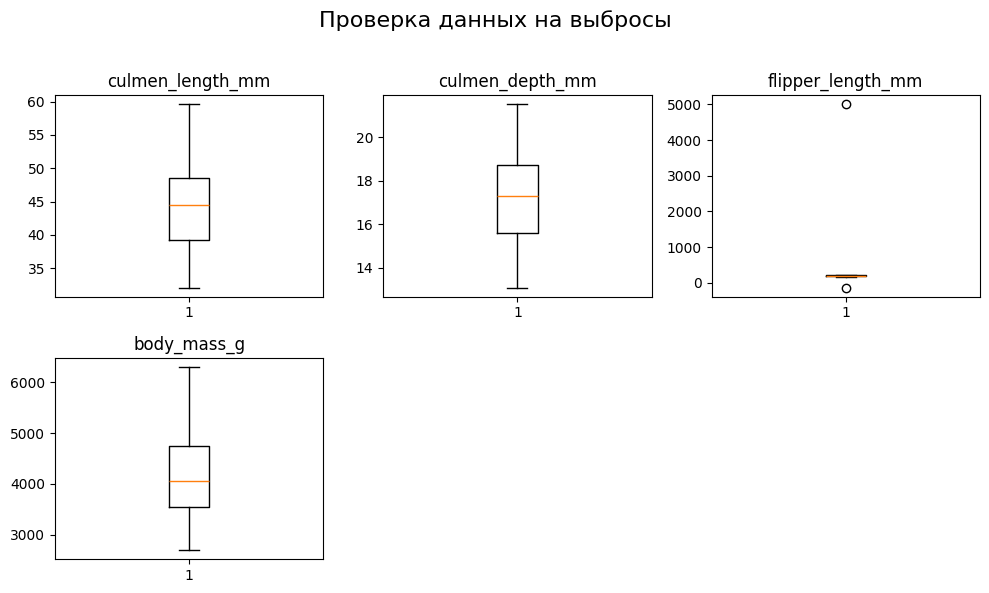

In [19]:
n = len(col_num)
ncols = 3  # Количество столбцов в сетке
nrows = (n + ncols - 1) // ncols  # Количество строк

# Создание фигуры и подграфиков
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3 * nrows))
axes = axes.flatten()  # Преобразование в одномерный массив для удобства

# Создание boxplot для каждого числового столбца
for i, column in enumerate(col_num):
    axes[i].boxplot(df[column])
    axes[i].set_title(column)  # Заголовок для каждого графика

# Удаление пустых подграфиков, если они есть
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
fig.suptitle("Проверка данных на выбросы", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Автоматическая настройка отступов
plt.show()  # Отображение графиков

In [20]:
df['flipper_length_mm'].sort_values(ascending=False).head()

9      5000.0
283     231.0
285     230.0
295     230.0
253     230.0
Name: flipper_length_mm, dtype: float64

In [21]:
df['flipper_length_mm'].sort_values().head()

14    -132.0
28     172.0
20     174.0
122    176.0
30     178.0
Name: flipper_length_mm, dtype: float64

Видим два аномальных значения в данных: 5000 мм и -132. Обработаем данные выбросы.

In [22]:
# Обработаем выбросы
def outliers_in_data(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    
    return df


df = outliers_in_data(df, ['flipper_length_mm'])

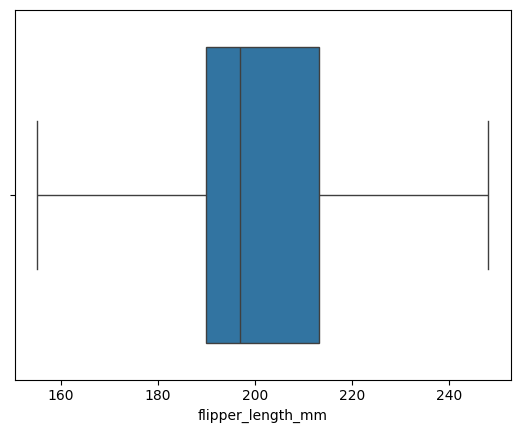

In [23]:
sns.boxplot(data=df, x='flipper_length_mm')
plt.show()

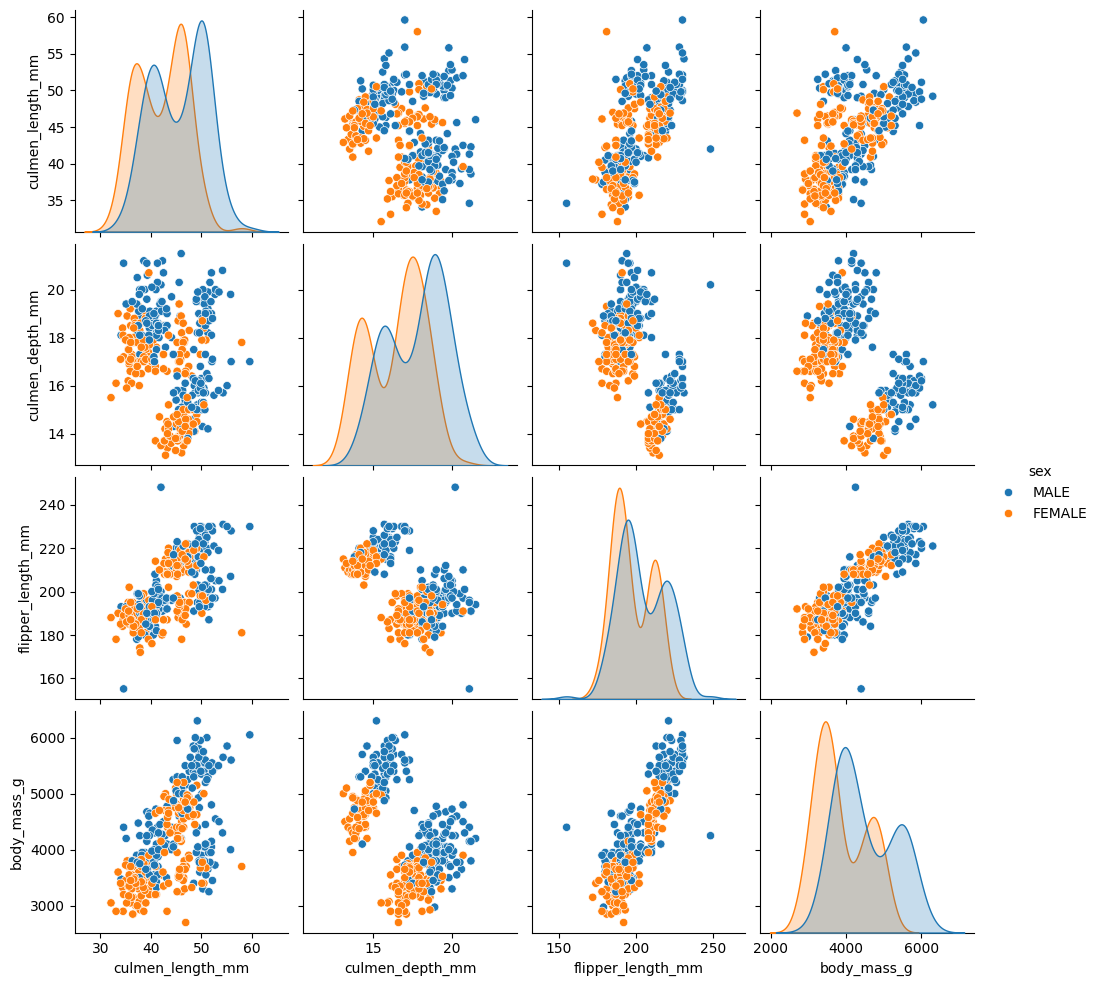

In [24]:
sns.pairplot(df, hue='sex')
plt.show()

## Проведем EDA после обработки

In [25]:
eda_num_info(df[col_num])

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
culmen_length_mm,0.0,32.100,59.600,43.925000,44.45,29.634869,36.6,50.8,39.275,48.50
culmen_depth_mm,0.0,13.100,21.500,17.152035,17.30,3.877197,14.3,19.5,15.600,18.70
flipper_length_mm,0.0,155.125,248.125,200.936773,197.00,208.906432,185.0,221.0,190.000,213.25
body_mass_g,0.0,2700.000,6300.000,4200.872093,4050.00,639514.543359,3300.0,5400.0,3550.000,4750.00


In [26]:
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
sex,0.0,2,MALE


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   344 non-null    float64
 1   culmen_depth_mm    344 non-null    float64
 2   flipper_length_mm  344 non-null    float64
 3   body_mass_g        344 non-null    float64
 4   sex                344 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


Пропуски и выбросы обработаны.

## Построим матрицу корреляции

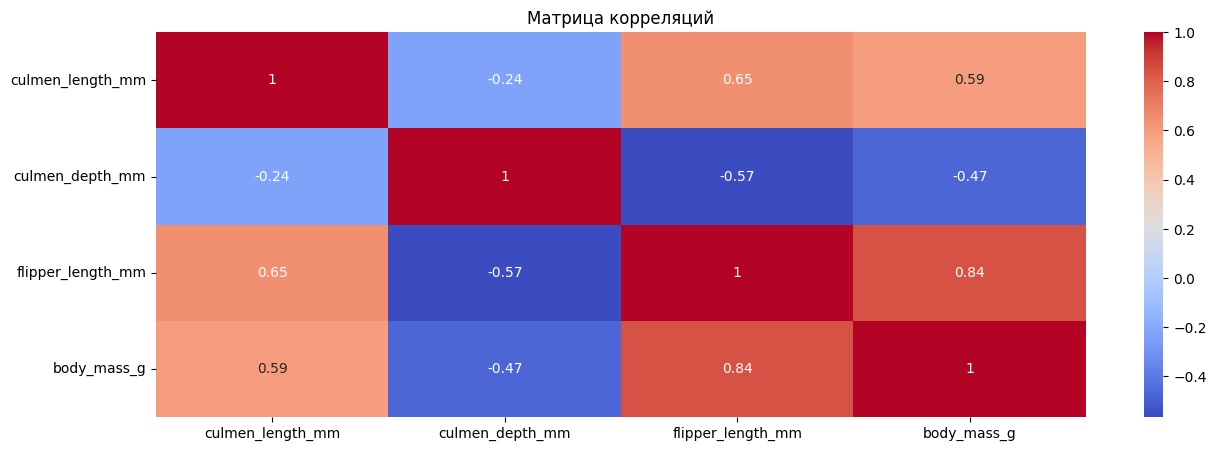

In [28]:
corr = df[col_num].corr()
plt.figure(figsize=(15,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Матрица корреляций")
plt.show()

Видим хорошую корреляцию между `flipper_length_mm и body_mass_g`, а также между `flipper_length_mm и culmen_length_mm`.

## Кодирование категориальных столбцов

In [29]:
# Кодирование категориального признака 'sex'
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])

df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.10,18.7,181.0,3750.0,1
1,39.50,17.4,186.0,3800.0,0
2,40.30,18.0,195.0,3250.0,0
3,44.45,17.3,197.0,4050.0,1
4,36.70,19.3,193.0,3450.0,0


## Нормализация данных

In [30]:
# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[col_num])
pd.DataFrame(X_scaled).head()

,0,1,2,3
0,-0.887622,0.787289,-1.381374,-0.564625
1,-0.814037,0.126114,-1.034935,-0.502010
2,-0.666866,0.431272,-0.411345,-1.190773
3,0.096581,0.075255,-0.272770,-0.188936
4,-1.329133,1.092447,-0.549921,-0.940314


## Кластеризация - Метод локтя

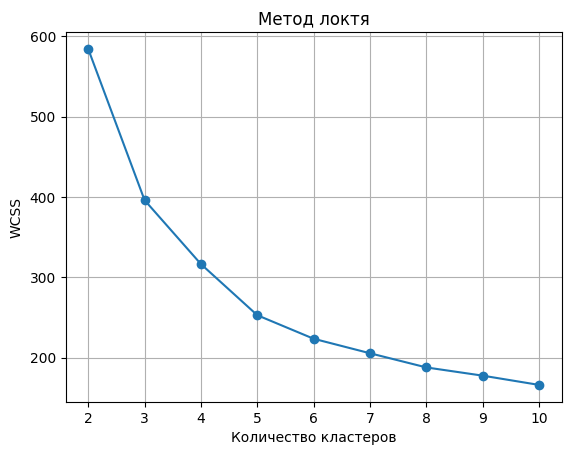

In [31]:
# Поиск оптимального числа кластеров методом локтя
wcss = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_values, wcss, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.title('Метод локтя')
plt.grid()
plt.show()

Методом локтя сложно определить количество кластеров в наших данных, какого-то явного и сильного изгиба не видно, возможно искомое значение в диапазоне от 3 до 6, после уже идет более плавный спуск графика.

## Кластеризация - метод силуэта

Для n_clusters = 2 Средний silhouette_score равен : 0.6054230300791397
Для n_clusters = 3 Средний silhouette_score равен : 0.5348931377400156
Для n_clusters = 4 Средний silhouette_score равен : 0.5037084064722266
Для n_clusters = 5 Средний silhouette_score равен : 0.47057026794668677
Для n_clusters = 6 Средний silhouette_score равен : 0.45115501904264227
Для n_clusters = 7 Средний silhouette_score равен : 0.428573021090281
Для n_clusters = 8 Средний silhouette_score равен : 0.3801186246435065
Для n_clusters = 9 Средний silhouette_score равен : 0.3747597089176763
Для n_clusters = 10 Средний silhouette_score равен : 0.3618270284115356


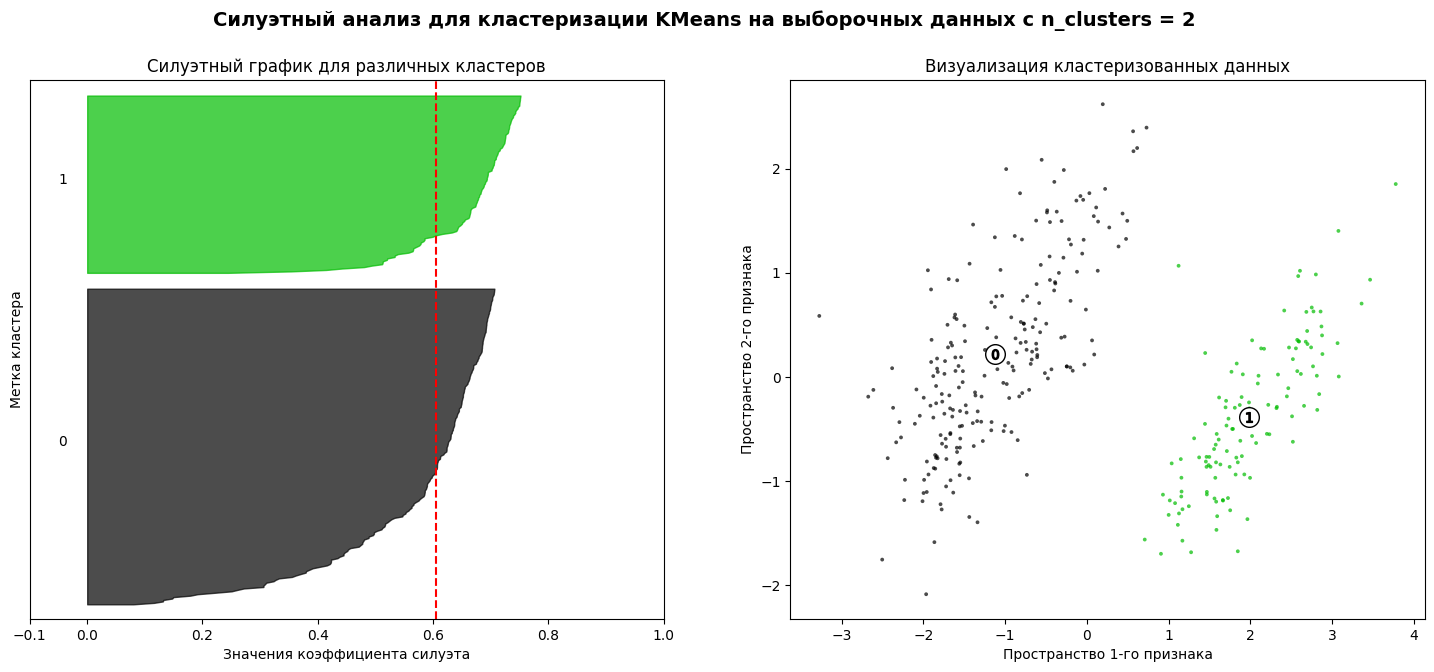

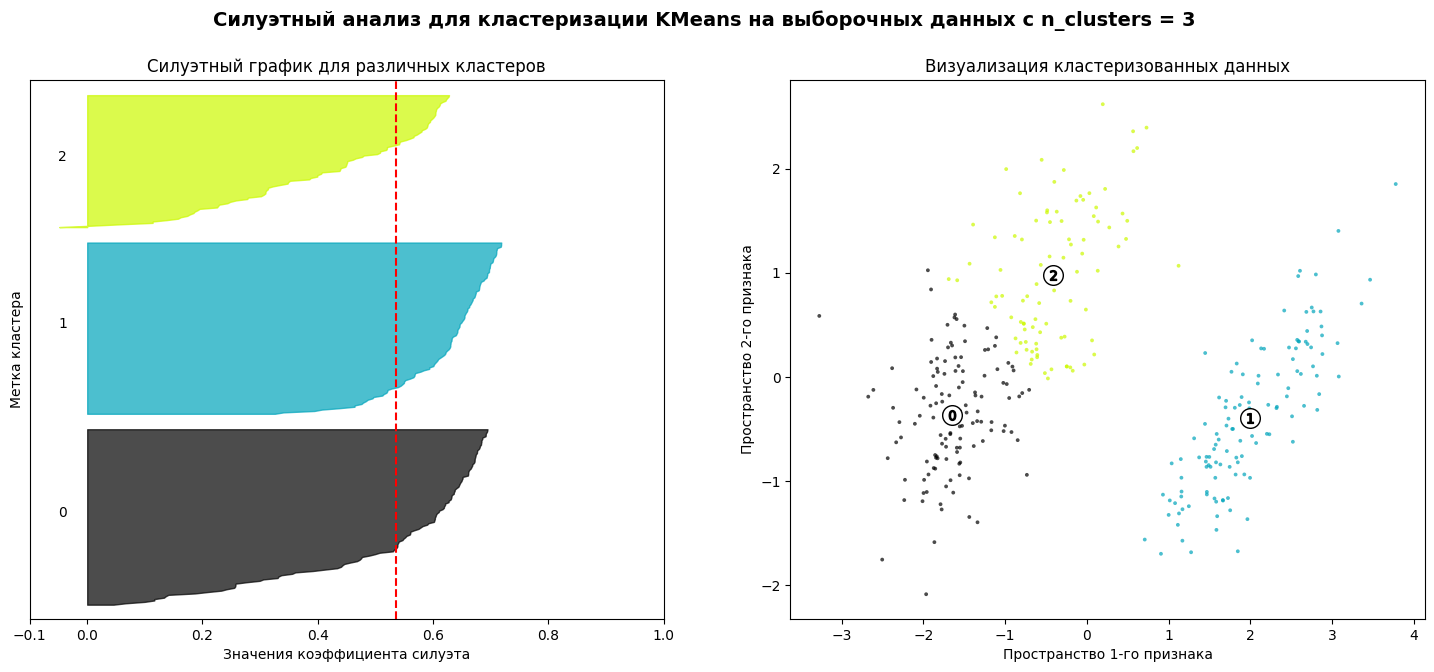

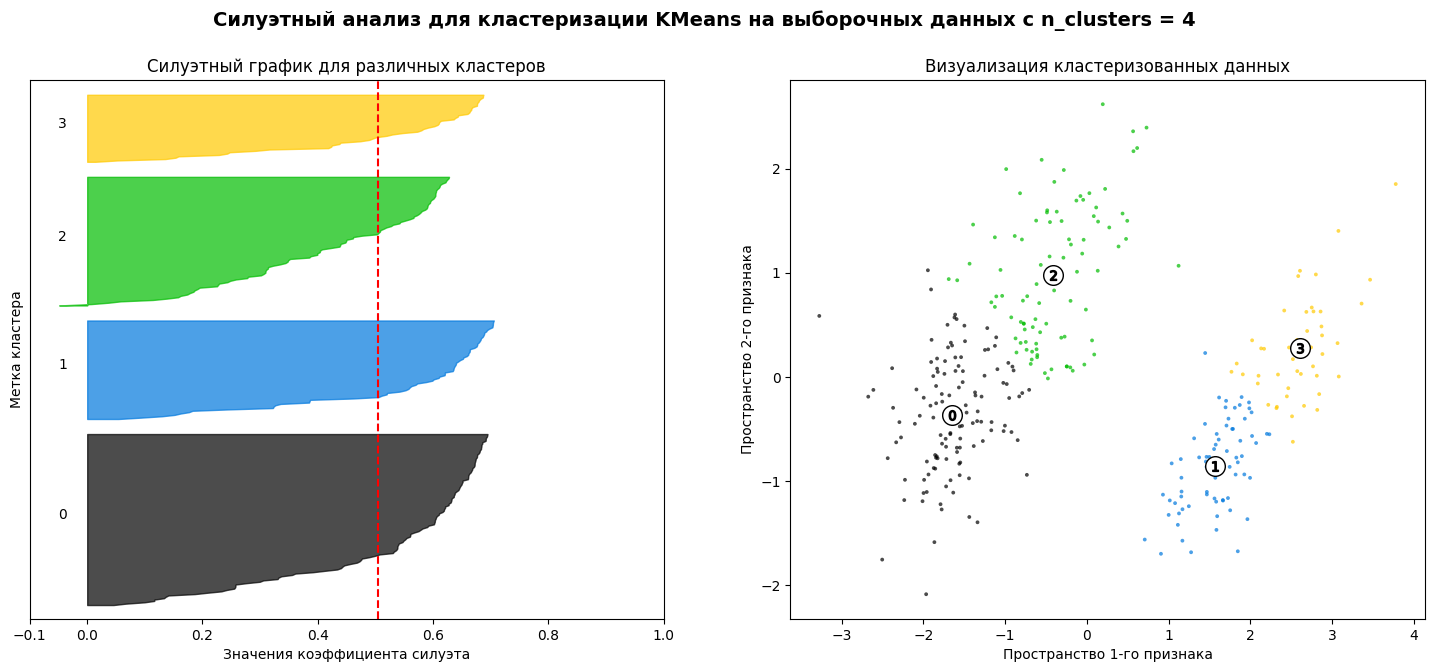

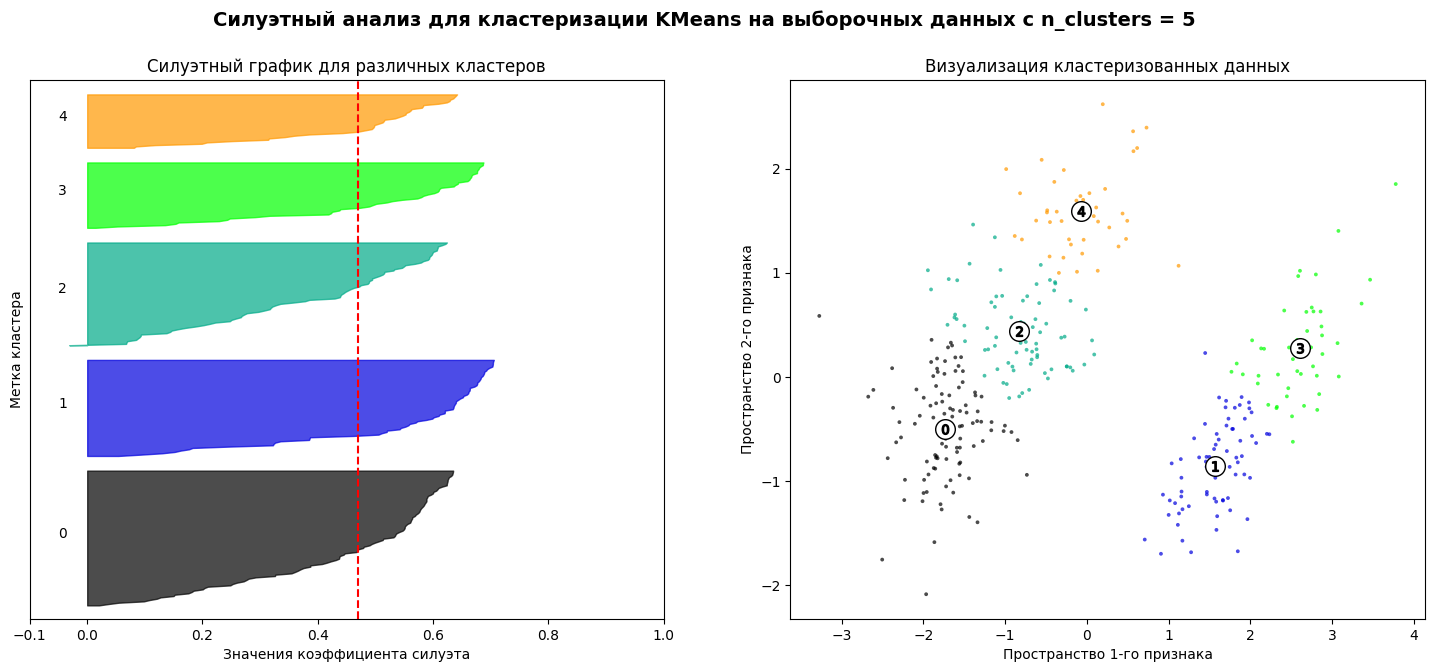

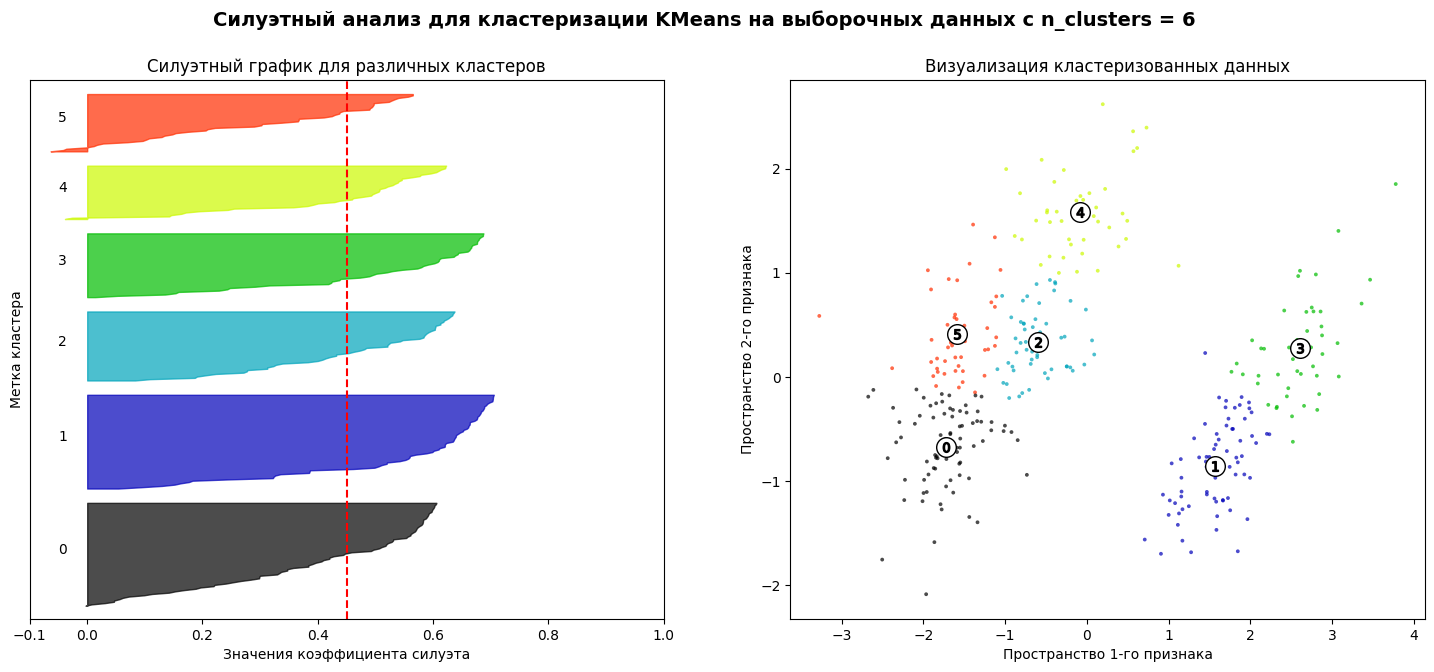

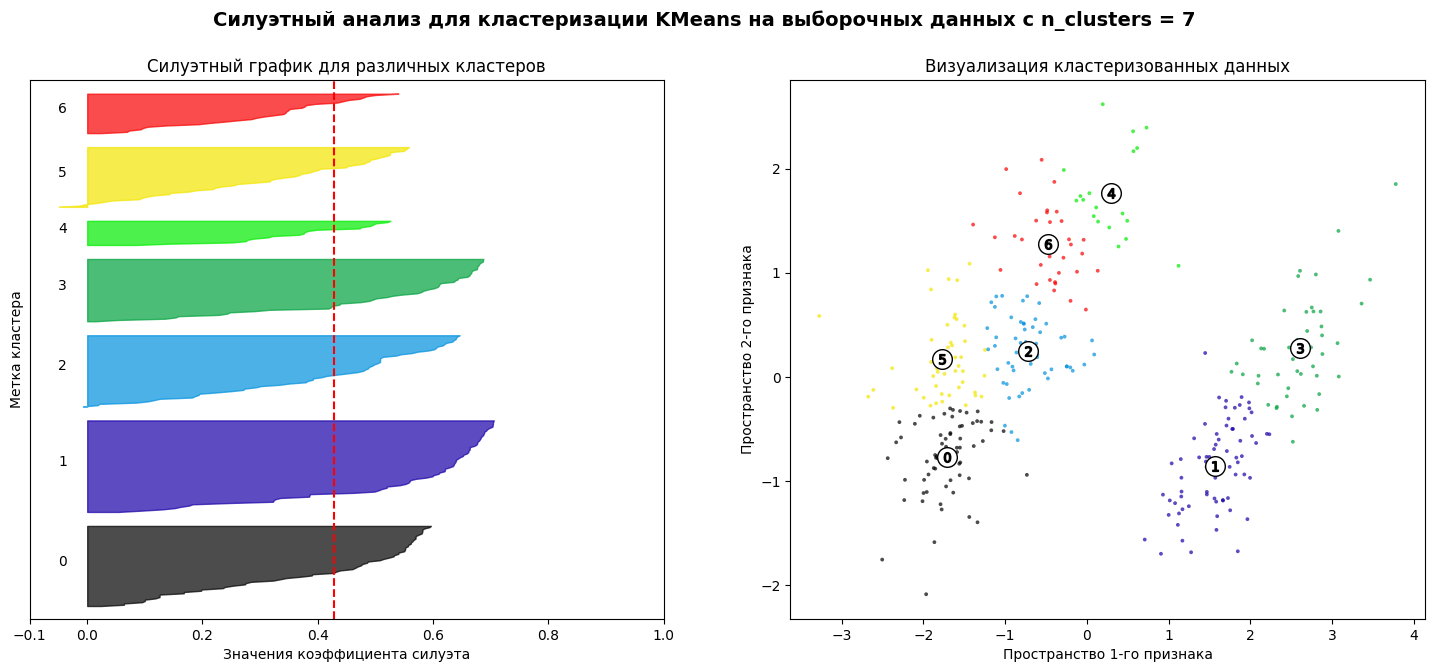

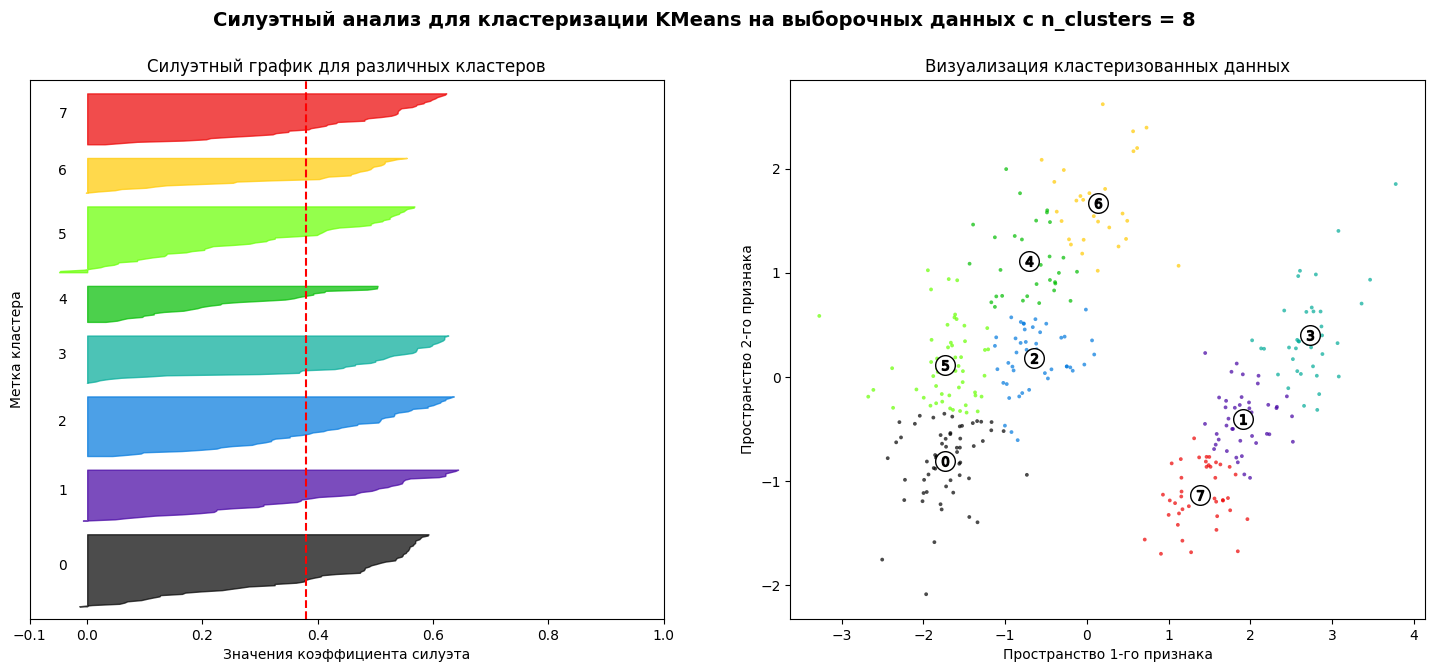

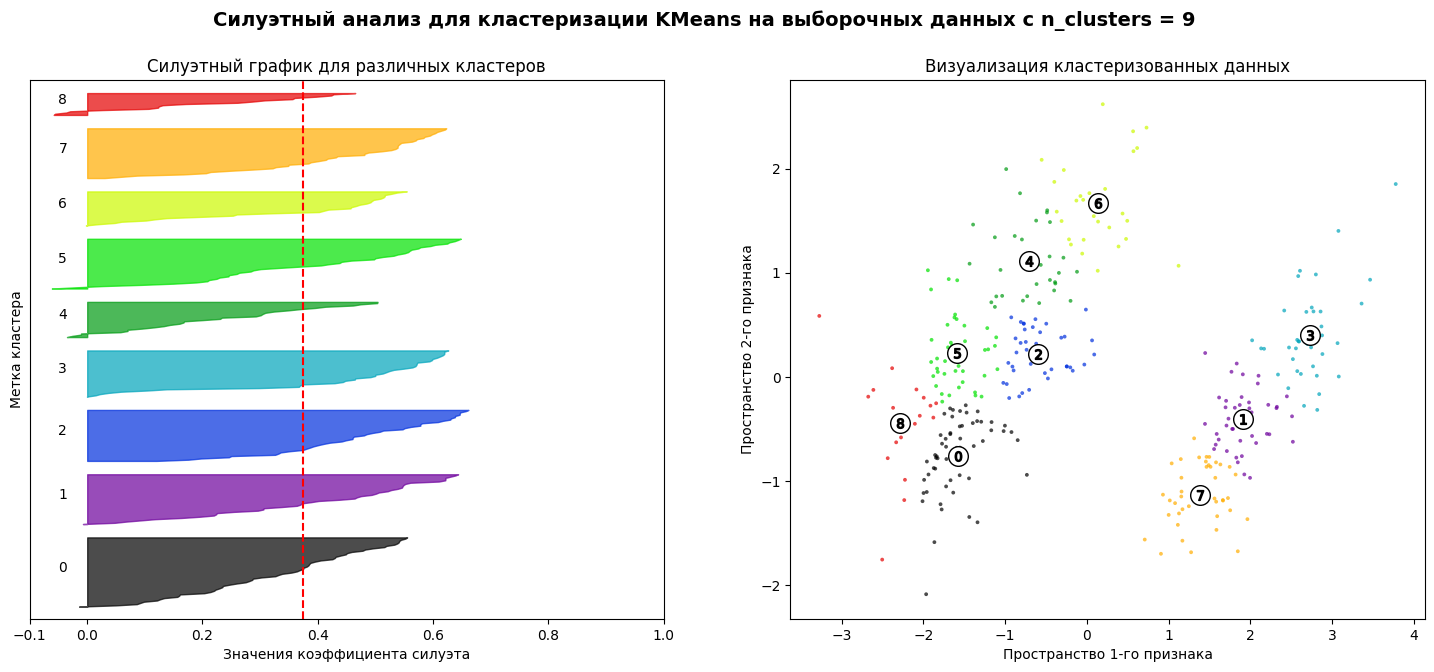

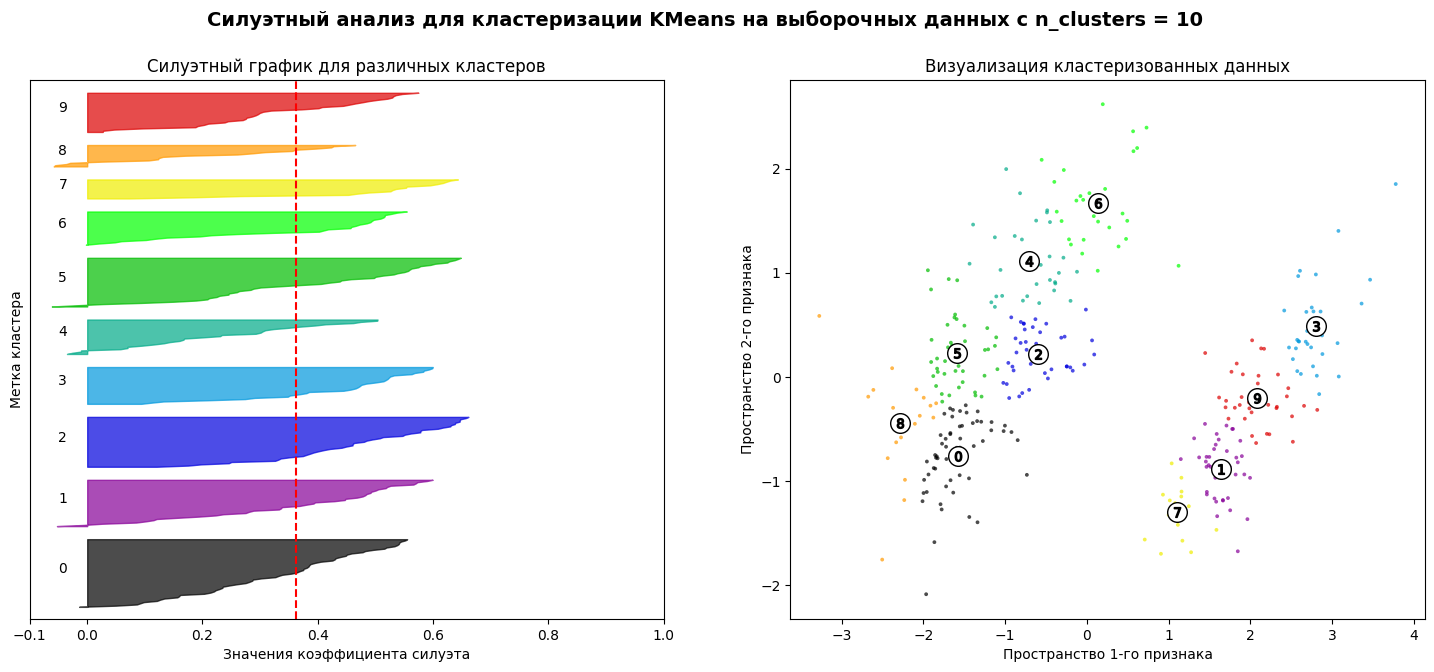

In [32]:
# Уменьшение размерности входных данных с помощью PCA
reduced_data = PCA(n_components=2).fit_transform(X_scaled) # использовать, когда более 3 признаков

# Создадим пустой список для записи коэффициентов силуэта для каждого образца
sample_silhouette_values = []

# Воспользуемся функцией range(), она возвращает последовательность чисел
# в данном случае числа от 1 до 10
min_range = 2
max_range = 11  # до максимального, не включая

for i in range(min_range, max_range):
    # Создайте подзаголовок с 1 строкой и 2 столбцами
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Первый подсюжет — это график силуэта
    # Коэффициент силуэта может варьироваться от -1 до 1, но в этом примере все
    # лежат в пределах [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # (n_clusters+1)*10 предназначен для вставки пустого пространства между силуэтами
    # графики отдельных кластеров, чтобы четко их разграничить.
    ax1.set_ylim([0, len(reduced_data) + (i + 1) * 10])

    # Инициализируем кластеризатор значением n_clusters и генератором случайных чисел
    # начальное число из 10 для воспроизводимости.
    clusterer = KMeans(n_clusters=i, random_state=42)
    cluster_labels = clusterer.fit_predict(reduced_data)

    # Silhouette_score дает среднее значение для всех образцов.
    # Это дает представление о плотности и разделении образовавшихся
    # clusters
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print(
        "Для n_clusters =", i, "Средний silhouette_score равен :", silhouette_avg,
    ) # рассчет коэффициента, можно без визуализации

    # Вычисляем оценки силуэта для каждого образца
    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    y_lower = 10
    for j in range(i):
        # Объединить оценки силуэтов для образцов, принадлежащих
        # кластер j и отсортируйте их
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / i)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            jth_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Пометьте графики силуэтов номерами их кластеров посередине.
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Вычисляем новый y_lower для следующего графика
        y_lower = y_upper + 10  # 10 для 0 образцов

    ax1.set_title("Силуэтный график для различных кластеров")
    ax1.set_xlabel("Значения коэффициента силуэта")
    ax1.set_ylabel("Метка кластера")

    # Вертикальная линия для средней оценки силуэта всех значений.
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Очистите метки/галочки Yaxis
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2-й график, показывающий фактически сформированные кластеры
    colors = cm.nipy_spectral(cluster_labels.astype(float) / i)
    ax2.scatter(
        reduced_data[:, 0], reduced_data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Маркировка кластеров
    centers = clusterer.cluster_centers_
    # Нарисуйте белые круги в центрах кластеров
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for k, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % k, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Визуализация кластеризованных данных")
    ax2.set_xlabel("Пространство 1-го признака")
    ax2.set_ylabel("Пространство 2-го признака")

    plt.suptitle(
        "Силуэтный анализ для кластеризации KMeans на выборочных данных с n_clusters = %d"
        % i,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Видим, что данные в принципе хорошо кластеризуются в диапазоне значений *n_clusters* от 2 до 10. При необходимости можно поделить данные на 10 кластеров, но насколько это оптимально - не понятно. Попробуем подобрать гиперпараметр *n_clusters* через `GridSearch`.

## Подбор гиперпараметров

In [33]:
# Функция silhouette_scorer
def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels)

# Подбор гиперпараметров с помощью GridSearchCV с silhouette_scorer
param_grid = {'n_clusters': range(2, 11),
              'n_init' : range(2, 11),
              'algorithm' : ["lloyd", "elkan"],
              'init': ['k-means++', 'random'],
              'max_iter': [100, 200, 300, 500, 1000]
            }
kmeans = KMeans(random_state=42)
grid_search = GridSearchCV(kmeans, param_grid,scoring=make_scorer(silhouette_scorer), cv=3, n_jobs=-1)
grid_search.fit(X_scaled)

best_params = grid_search.best_params_
print(f'Лучшие параметры: {best_params}')


Лучшие параметры: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 2, 'n_init': 2}


Видим, что наилучшее число кластеров в наших данных это 2. Посмотрим, какие кластеры мы получили.

## Проверка полученных кластеров

In [34]:
# Обучение KMeans с оптимальными параметрами
best_kmeans = KMeans(**best_params, random_state=42)
df['clusters'] = best_kmeans.fit_predict(X_scaled)


In [35]:
df.head(10)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,clusters
0,39.10,18.7,181.000,3750.0,1,0
1,39.50,17.4,186.000,3800.0,0,0
2,40.30,18.0,195.000,3250.0,0,0
3,44.45,17.3,197.000,4050.0,1,0
4,36.70,19.3,193.000,3450.0,0,0
5,39.30,20.6,190.000,3650.0,1,0
6,38.90,17.8,181.000,3625.0,0,0
7,39.20,19.6,195.000,4675.0,1,0
8,34.10,18.1,193.000,3475.0,1,0
9,42.00,20.2,248.125,4250.0,1,1


In [36]:
df['clusters'].value_counts()

clusters
0    220
1    124
Name: count, dtype: int64

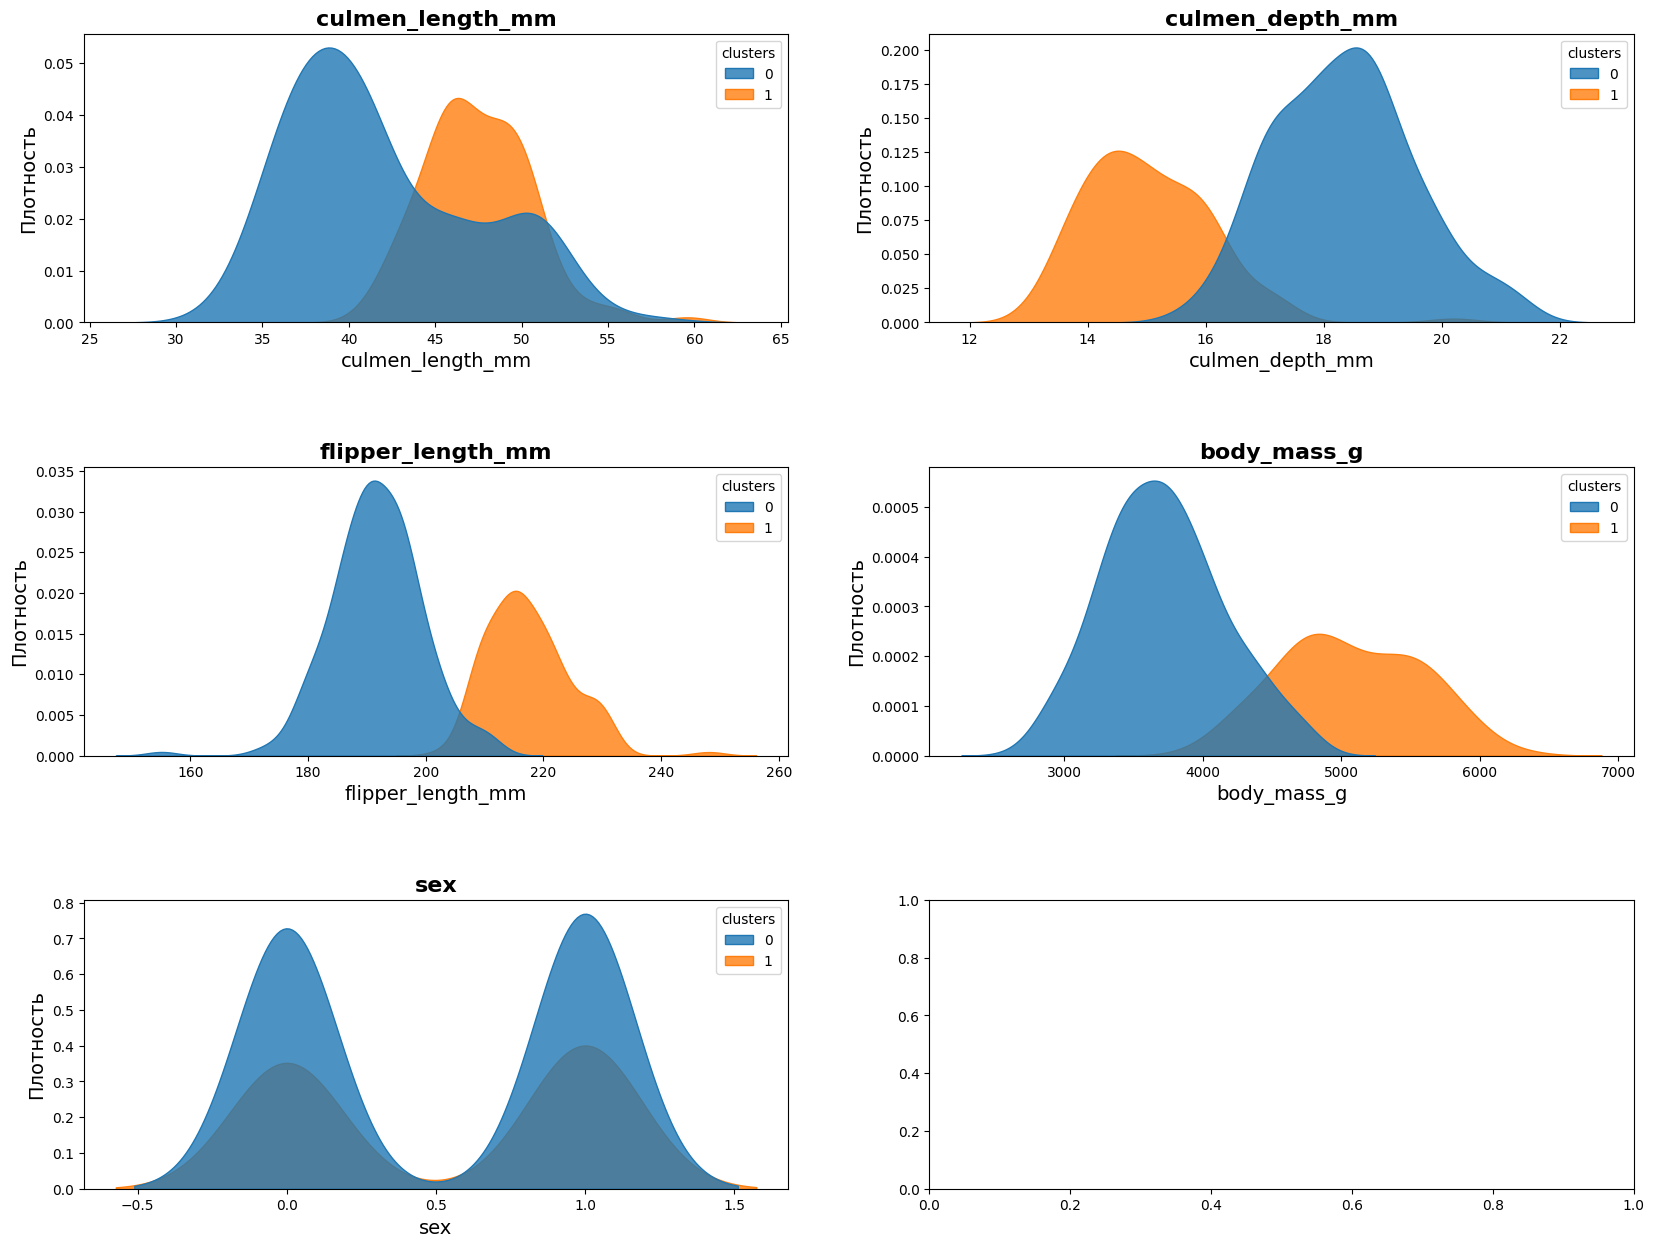

In [37]:
# Создаем матрицу графиков для визуализации распредления по каждой переменной
fig, axes = plt.subplots(3,2, figsize = (20,15))

# Расстояние между графиками
plt.subplots_adjust(hspace=0.5)

# Список значений признаков для цикла
columns = df.columns[:-1]

# Строим распределения (kdeplot) для каждого признака
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data = df,
                x = column,
                fill = True,
                alpha = 0.8,
                hue = 'clusters',
                ax = ax)
    
    ax.set_title(column, fontweight = 'bold', fontsize = 16)
    ax.set_xlabel(column, fontsize = 14)
    ax.set_ylabel('Плотность', fontsize = 14)
    

plt.show()

### Средние значения для каждого кластера по категориям

In [38]:
df_mean = df.groupby('clusters').agg({'culmen_length_mm' : 'mean',
                                      'culmen_depth_mm' : 'mean',
                                      'flipper_length_mm' : 'mean',
                                      'body_mass_g' : 'mean'
                                      })

df_mean.index.name = None
df_mean = round(df_mean,2)
df_mean

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,41.93,18.35,191.64,3711.36
1,47.46,15.02,217.44,5069.35


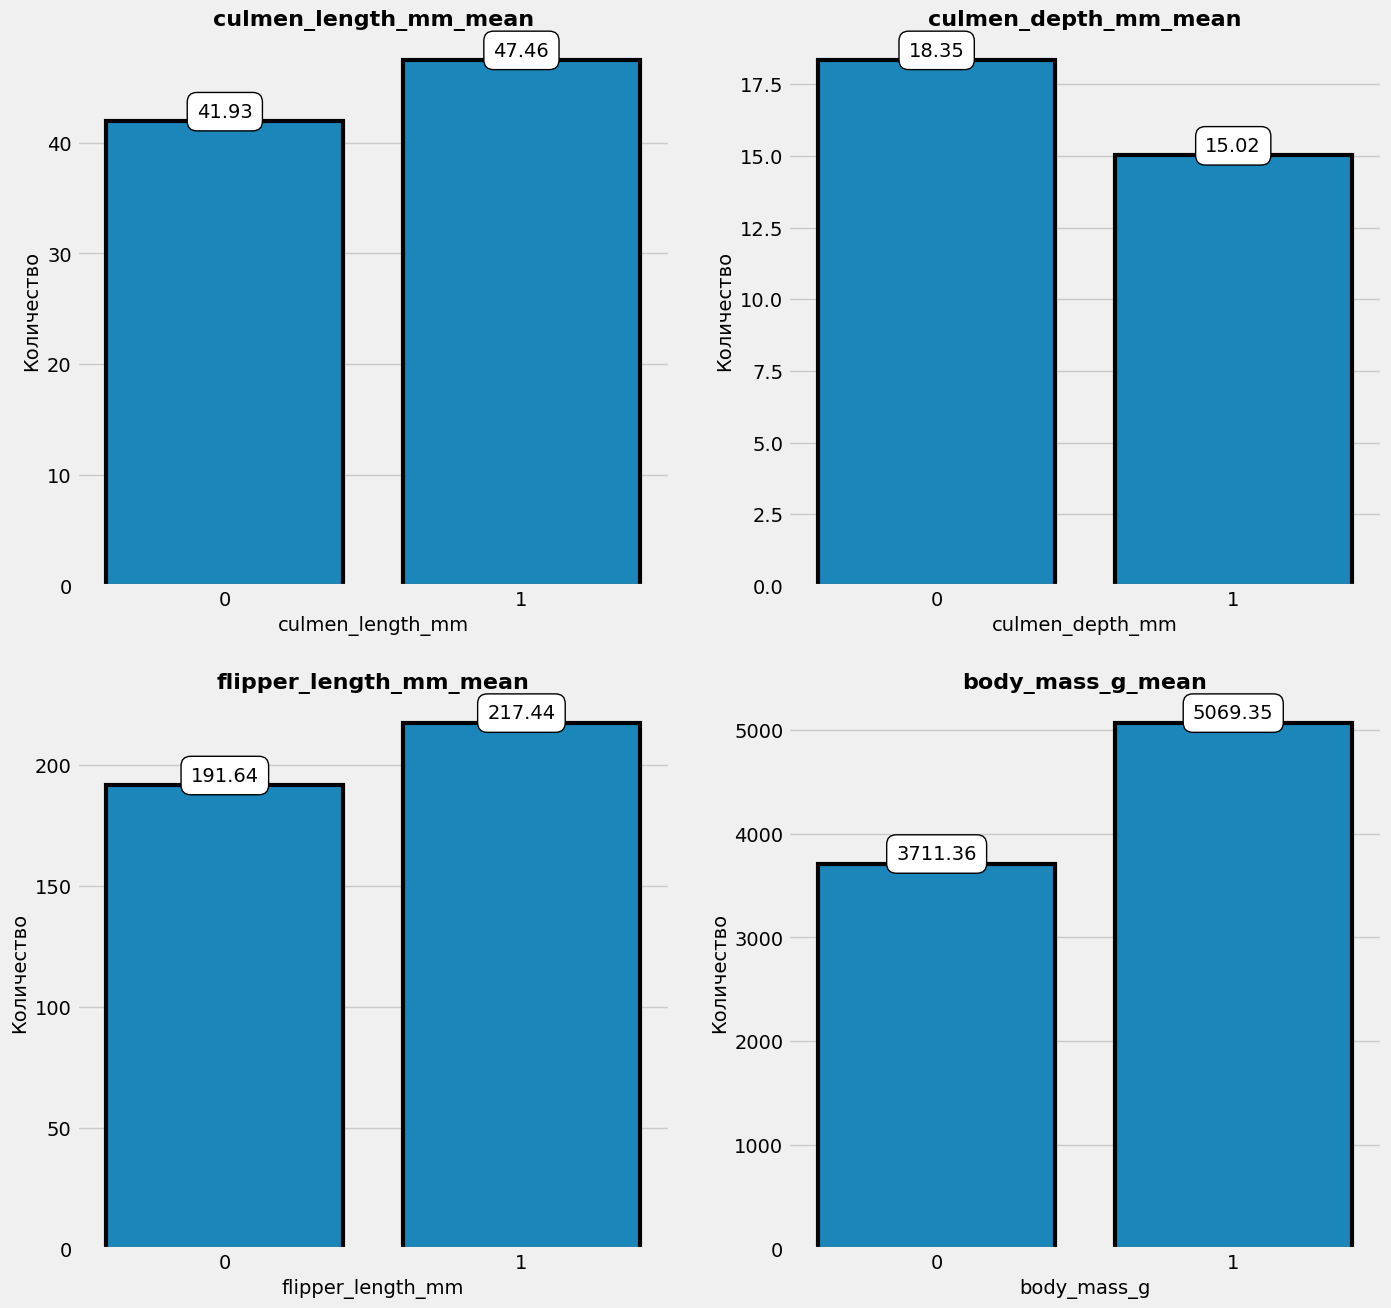

In [39]:
bbox = {'boxstyle' : 'round',
        'pad' : 0.5,
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1,
        'alpha' : 1}

plt.style.use('fivethirtyeight')

# Создаем матрицу графиков для визуализации распредления по каждой переменной
fig, axes = plt.subplots(2,2, figsize = (15,15))

# Расстояние между графиками

# Список значений признаков для цикла
columns = df_mean.columns

# Строим распределения (kdeplot) для каждого признака
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    p1 = sns.barplot(data = df_mean,
                x = df_mean.index,
                y = column,
                linewidth = 3,
                edgecolor = 'black',
                ax = ax)
    p1.bar_label(p1.containers[0], bbox = bbox)
    
    ax.set_title(f'{column}_mean', fontweight = 'bold', fontsize = 16)
    ax.set_xlabel(column, fontsize = 14)
    ax.set_ylabel('Количество', fontsize = 14)
    

plt.show()

Видим различия между кластерами по столбцам. У пингвинов класса 1 по сравнению с классом 0 больше масса тела, больше длина ласт и верхнего края клюва, а значение глубины верхнего края клюва наоборот меньше. 

### Сохранение лучшей модели на диск

In [40]:
# Сохранение модели
joblib.dump(best_kmeans, 'kmeans_penguins.joblib')

['kmeans_penguins.joblib']